輸入立委臉書粉專內容及選舉政見資料

In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019立委_research.csv')
politics = pd.read_csv('9th_legislator_promise.csv')
fb.page_name.unique() #觀察人名在資料集中叫什麼名字
politics.姓名.unique()

array(['吳思瑤', '姚文智', '何志偉', '蔣萬安', '李彥秀', '林昶佐', '蔣乃辛', '費鴻泰', '賴士葆',
       '呂 孫 綾', '林 淑 芬', '高志鵬', '余天', '吳 秉 叡', '蘇 巧 慧', '張 宏 陸', '羅 致 政',
       '江 永 昌', '林 德 福', '吳 琪 銘', '羅 明 才', '黃 國 昌', '蔡適應', '鄭 運 鵬',
       '陳賴素美', '陳學聖', '鄭寶清', '呂玉玲', '趙正宇', '林為洲', '柯建銘', '陳超明', '徐志榮',
       '蔡其昌', '顏寬恒', '洪慈庸', '張廖萬堅', '盧秀燕', '沈智慧', '黃國書', '何欣純', '江啟臣',
       '王惠美', '柯呈枋', '黃秀芳', '洪宗熠', '陳素月', '馬 文 君', '許 淑 華', '蘇 治 芬',
       '劉 建 國', '李 俊 俋', '蔡 易 餘', '陳 明 文', '葉宜津', '黃偉哲', '郭國文  ', '陳亭妃',
       '林俊憲', '王定宇', '邱 議 瑩', '邱 志 偉', '劉 世 芳', '林 岱 樺', '管 碧 玲', '李 昆 澤',
       '趙 天 麟', '馬 凱 妮', '賴 瑞 隆', '蘇震清', '鍾佳濱', '莊瑞雄', '陳歐珀', '蕭美琴',
       '劉櫂豪', '楊 曜', '楊鎮浯', '陳玉珍', '陳雪生', '廖國棟', '鄭天財', '陳瑩', '高金素梅',
       '簡東明', '孔文吉', nan], dtype=object)

以新北市立委呂孫綾為例，建立發文文字斷詞表

In [3]:
lu = fb[fb.page_name == "呂孫綾"]
lu.head(1)

,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,link_name,link_description,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count
6749,932173560139717_2266532516703808,932173560139717,呂孫綾,公眾人物,#行政院長蘇貞昌拜會立法院囉,NaN,photo,https://www.facebook.com/932173560139717/posts/2266532516703808/,2019-01-15T03:35:55+0000,2019-01-15T11:35:55,...,NaN,NaN,257,0,0,0,0,0,8,8


In [4]:
lu['new_date'] = pd.to_datetime(lu['created_time_taipei']).dt.date
lu['month_year'] = pd.to_datetime(lu['new_date']).dt.to_period('M')
lu.head(1)

<ipython-input-4-e20a05360db0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['new_date'] = pd.to_datetime(lu['created_time_taipei']).dt.date
<ipython-input-4-e20a05360db0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lu['month_year'] = pd.to_datetime(lu['new_date']).dt.to_period('M')


,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,month_year
6749,932173560139717_2266532516703808,932173560139717,呂孫綾,公眾人物,#行政院長蘇貞昌拜會立法院囉,NaN,photo,https://www.facebook.com/932173560139717/posts/2266532516703808/,2019-01-15T03:35:55+0000,2019-01-15T11:35:55,...,257,0,0,0,0,0,8,8,2019-01-15,2019-01


In [5]:
# 依照按讚數 低到高排序
lu = lu.sort_values(by=['like_count'])
# 用新的排序當作順序
lu.reset_index(inplace=True)

結巴斷詞 jieba

1.   len(liu): 看劉櫂豪的貼文總共有幾筆
2.   list(liu['message']): 把要斷詞的內容轉成 list 格式
3.   創造一個新的dataframe叫做liu_docs，型態是pandas.core.frame.DataFrame
4.   原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [6]:
doc_names = range(len(lu)) #有幾篇文章 : 444 篇文章
doc_names

range(0, 476)

In [7]:
lu = lu.replace(np.nan, '', regex=True) # 將nan取代成空白字串
text_list = list(lu['message']) # 把所有message轉成一個list 用for iterate

What is the difference between lcult() & cut()

In [8]:
# 先看第一個
words = jieba.lcut(text_list[0], cut_all = False) # lcut return a "list"
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.676 seconds.
Prefix dict has been built succesfully.


['各位', '鄉親', '朋友', '們', '照過', '來', '！', '\n', '泰山', '同興', '停車場', '月租', '登記', '及', '抽', '籤', '辦法開', '跑', '囉', '🅿', '️', '\n', '\n', '🔸', '登記', '方式', '：', '\n', 'ㄧ', '、', '線上', '登記', '：', 'http', ':', '/', '/', 'spencer16161.000', 'webhostapp', '.', 'com', '/', 'parkinglot', '/', '\n', '二', '、', '現場', '登記', '：', '攜帶', '行照', '、', '駕照', '、', '身分', '證至', '管理室', '辦理', '\n', '(', '代理', '申請', '也', '需攜帶', '申請', '人', '之', '上述', '證件', ')', '\n', '\n', '🔸', '停車場', '位置', '：', '\n', '新北市', '泰山', '區福興', '一街', '、', '同義街', '18', '巷', '轉角', '\n', '\n', '若有', '疑問', '請洽', ' ', '聯中', '誠', '有限公司', ' ', '02', '-', '8531', '-', '6494']


In [9]:
words = jieba.cut(text_list[0], cut_all = False) 
print(words)
#for word in words:
 #   print(word)

<generator object Tokenizer.cut at 0x00000261B0539C10>


把要存斷詞結果的dataframe準備好之後，就可以開始斷詞了。</br>

第一個迴圈</br> 剛才我們知道，劉櫂豪的篇數有999篇： 我們可以用一個for迴圈來跑每一篇文章，i是對應文章的意思，會從1(第一篇)跑到999(第999篇)；</br> 而text_list就是我們剛剛轉成list型態的劉櫂豪貼文內容；text_list[1]，就是取出list第一個元素(第一篇貼文)的意思。</br>

第二個迴圈</br> words存的是文章斷詞後的集合物件(object)，我們需要跑第二個for迴圈把集合裡面的字取出來，</br> word代表斷詞集合中的一個字，先把字轉換成str(字串)型態之後，字和字之間加上空格存在一起。

append加回斷詞欄位</br> 之後把text內容存到'jieba_results'這個欄位裡面，再和liu_docs合併。</br> 最後我們liu_docs，只會一個欄位jieba_results，存斷詞之後的結果。

In [41]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")
punctuation = " //，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
lu_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
lu_docs['jieba_results'] = lu_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text) # 把上面那些符號從text中刪掉
    text = re.sub(r'[0-9]','',text) # 刪掉數字
    text = re.sub(r'[a-zA-Z]','',text) #刪掉英文字
#刪除文字 更多標點符號
    text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗🎉⏰💪]','',text)  # 注意裡面不能有空白！
    s = pd.Series({'jieba_results': text})
    lu_docs = lu_docs.append(s, ignore_index=True)#每次的斷詞結果都加回liu_docs


In [42]:
#liu_docs.iloc[400:,]  #從讚數最多的檢查

In [43]:
lu['jieba_results'] = lu_docs
lu_post = lu[['new_date','message','jieba_results','like_count']]
lu_post

,new_date,message,jieba_results,like_count
0,2019-01-05,各位鄉親朋友們照過來！\n泰山同興停車場月租登記及抽籤辦法開跑囉🅿️\n\n🔸登記方式：\nㄧ、線上登記：http://spencer16161.000webhostapp.com/parkinglot/\n二、現場登記：攜帶行照、駕照、身分證至管理室辦理\n(代理申請也需攜帶申請人之上述證件)\n\n🔸停車場位置：\n新北市泰山區福興一街、同義街18巷轉角\n\n若有疑問請洽 聯中誠有限公司 02-8531-6494,各位 鄉親 朋友 們 照過 來 泰山同興停車場 月租登記 及 抽籤辦法 開跑 囉 🅿 ️ 🔸 登記 方式 ㄧ 線上 登記 二 現場 登記 攜帶 行照 駕照 身分 證至 管理室 辦理 代理 申請 也 需攜帶 申請 人 之 上述 證件 🔸 停車場 位置 新北市 泰山 區福興 一街 同義街 巷 轉角 若有 疑問 請洽 聯中 誠 有限公司,121
1,2019-01-26,大家早安！\n豬年系列活動今天來到【八里區文化活動中心】\n今天的春聯是不是很不一樣呢！\n大師揮毫贈春聯活動再半小時就要開始囉！\n趕快來排隊以免向隅喔！,大家 早安 豬年 系列 活動 今天 來 到 八里 區 文化 活動 中心 今天 的 春聯 是不是 很 不 一樣 呢 大師揮 毫贈 春聯 活動 再 半小時 就要 開始 囉 趕快 來 排隊 以免 向隅 喔,124
2,2019-01-24,台灣的校園、公園，甚至許多百貨公司賣場裡，都有設置兒童遊戲場；隨著時代的演變，對於兒童遊戲場的安全，家長也越來越重視。政府在前年，也修正頒布了「兒童遊戲場設施安全管理規範」，要求所有的兒童遊戲場3年內必須要通過檢驗，向政府備查；但是到目前，在全國一萬多處遊戲場中，卻僅有11.54%有完成備查。這其中除了有檢驗機構能量不足的問題，還有政府的經費與輔導不足的問題，造成有一些遊戲場因為沒有經費改善，索性就拆除掉，反而影響了兒童的遊戲權益。\n\n今天我與蘇巧慧委員、何欣純委員、吳焜裕委員、李麗芬委員、張宏陸委員、張廖萬堅委員一起舉辦「就要好玩又安全-談兒童遊戲場安全檢驗」公聽會，就是希望在實務面、法規面，大家集思廣益，了解問題；而今天的公聽會中，大家也暢談各種遇到的困難，未來我和各位委員，也會在立法院裡，持續與行政部門討論，不論是經費的爭取，或者是法規的修正，讓我們的兒童遊戲場能夠真正成為好玩又安全的特色遊戲場，小朋友能夠有一個遊玩的好去處與快樂的童年記憶！,台灣 的 校園 公園 甚至 許多百貨 公司 賣場裡 都 有 設置 兒童遊戲場 隨著 時代 的 演變 對 於 兒童遊戲場 的 安全 家長 也 越來 越 重視 政府 在 前年 也 修正 頒布 了 兒童遊戲場 設施 安全 管理 規範 要求 所有 的 兒童遊戲場 年 內 必須 要 通過 檢驗 向 政府 備查 但是 到 目前 在 全國 一萬 多處 遊戲場 中 卻僅 有 有 完成 備查 這 其中 除了 有 檢驗 機構 能量 不足 的 問題 還有 政府 的 經費 與 輔導 不足 的 問題 造成 有 一些 遊戲場 因為 沒有 經費 改善 索性 就 拆除 掉 反而 影響 了 兒童 的 遊戲 權益 今天 我 與 蘇巧慧 委員 何欣純 委員 吳焜裕 委員 李麗芬 委員 張宏陸 委員 張廖萬堅 委員 一起 舉辦 就要 好玩 又 安全 談 兒童遊戲場 安全 檢驗 公聽會 就是 希望 在 實務面 法規面 大家 集思廣益 了解 問題 而 今天 的 公聽會 中 大家 也 暢談 各種 遇到 的 困難 未來 我 和 各位 委員 也 會 在 立法院 裡 持續 與 行政部 門討論 不論 是 經費 的 爭取 或者 是 法規 的 修正 讓 我們 的 兒童遊戲場 能夠 真正 成為 好玩 又 安全 的 特色 遊戲場 小朋友 能夠 有 一個 遊玩 的 好 去 處 與 快樂 的 童年 記憶,137
3,2019-02-03,【大師揮毫贈春聯&親子黏土春聯 🐽年系列活動圓滿落幕】\n\n今年我所舉辦的春節系列活動壓軸場，藉著親子黏土春聯活動，在充滿小朋友歡笑聲的林口竹林山觀音寺圓滿落幕囉🎉\n\n每年我都會舉辦的手作黏土春聯活動，除了自己特別喜歡看見孩子的笑容，更希望藉著這個場合，讓把拔馬麻陪著孩子，帶回一起完成的作品，度過溫馨美滿的一年，也在孩子心中留下難忘的美好的記憶。\n\n特別感謝今年參與活動的各位阿公、阿嬤、爸爸、媽媽，以及最重要的孩子們，明年我會再帶來更有趣的春節系列活動，請大家拭目以待吧❤️更多精采活動訊息，也請持續關注我的FB粉絲專頁，以及LINE官方帳號😊\n\n#我們明年見\n#新年快樂豬事大吉\n\n來加入我的LINE吧：\nhttp://line.me/ti/p/@oet6682l\n來追蹤我的IG吧：\nhttps://www.instagram.com/lusunling/\n來訂閱我的YouTube頻道吧：\nhttps://www.youtube.com/channel/UC6PkFRPqDx65UGjSKwvFwKA,大師揮 毫贈 春聯 親子 黏土 春聯 🐽 年 系列 活動 圓滿 落幕 今年 我 所 舉辦 的 春節 系列 活動 壓軸場 藉 著 親子 黏土 春聯 活動 在 充滿 小朋友 歡笑聲 的 林口 竹林 山觀 音寺 圓滿 落幕 囉 每年 我 都 會 舉辦 的 手作 黏土 春聯 活動 除了 自己 特別 喜歡 看見 孩子 的 笑容 更 希望 藉 著 這個 場合 讓 把 拔馬麻 陪 著 孩子 帶回 一起 完成 的 作品 度過 溫馨 美滿 的 一年 也 在 孩子 心中 留下 難 忘 的 美好 的 記憶 特別 感謝 今年 參與 活動 的 各位 阿公 阿嬤 爸爸 媽媽 以及 最 重要 的 孩子 們 明年 我會 再 帶 來 更 有趣 的 春節 系列 活動 請 大家 拭目以待 吧 ❤ ️ 更 多 精采 活動訊息 也 請 持續 關注 我 的 粉絲 專頁 以及 官方 帳號 😊 我們 明年 見 新年 快樂 豬事 大吉 來 加入 我 的 吧 @ 來 追 蹤 我 的 吧 來 訂閱 我 的 頻道 吧,137
4,2019-03-18,⚓️【臺北港國防知性之旅】倒數5天！\n\n午安！大家是不是也和我一樣很期待！\n今天中午，就讓國防部的精彩活動預告片陪你吃午餐吧❤️\n\n孫綾與您3月23日臺北港見！,⚓ ️ 臺北港 國防 知性 之旅 倒數 天 午安 大家 是不是 也 和 我 一樣 很 期待 今天 中午 就 讓 國防部 的 精彩 活動 預告片 陪 你 吃 午餐 吧 ❤ ️ 孫綾 與 您 月 日 臺北港 見,144
...,...,...,...,...
471,2019-10-08,【呂孫綾爭取淡水北海岸設置大型醫院 蘇貞昌院長：全力支持】\n\n淡海新市鎮從開發到現在已經將近30年的時間，在2013年國民黨執政時，淡海新市鎮進行第二次通盤檢討，當時的執政者認定淡水北海岸地區的醫療資源已經足夠，未來也沒有新增大型醫院的需要，結果把唯一一塊大型醫院進駐的醫療專用區，變更成了倉儲專用區，讓我們淡海新市鎮失去可以設置大型醫療機構的機會，我認為這樣的變更不僅是非常的錯誤、沒有遠見，更是沒有看到我們地方的實際狀況，與未來發展的願景與需要！\n\n所以我上任之後，一直不斷的爭取要有醫療用地的規劃，這個過程是非常的艱難；2016年時，我上任時的第一次質詢，當時還是國民黨執政時期的張善政院長備詢，他回答說淡水北海岸的醫療資源已經足夠，未來新市鎮也不會有30萬人進駐，所以等到以後有需要再說！我非常不同意這樣的看法，一個錯誤的政策，是比貪汙還要可怕，更何況這將會影響淡水北海岸地區的未來發展！\n\n我們可以看到這幾年的發展，包含淡海新市鎮人口在10年內的快速成長、淡水區成為新北市人口成長最快區域、淡海輕軌與淡江大橋的通車與動工，都讓這裡的都市發展加速成長倍增，同時串聯八里台北港特定區與林口新市鎮，成為北台灣深具潛力的新都心；因此一處大型醫療用地不但需要，而且非常的急迫！\n\n因此在這三年多以來，我不斷的努力研究，包含淡水北海岸醫療分區的病床分布、跨區就醫、交通狀況、人口成長等等各項資訊，並且不斷的和內政部、衛福部進行溝通協調，並且向林全院長、賴清德院長提出質詢，也感謝他們同意將設置醫療用地納入淡海新市鎮後續發展的評估。\n\n終於在今天的施政總質詢中，蘇貞昌院長當面承諾，基於淡海地區人口快速增加、地方的切實需求，以及政府推動在地就醫減少民眾旅途勞頓、緩不濟急的理念，對於我不斷要求的設置醫療用地，在後續淡海新市鎮通盤檢討中，行政院將全力支持！\n\n這一刻我可以說是非常的興奮，也很高興，經過這麼久的努力，不負鄉親們的期盼，終於獲得院長明確的政策承諾，讓我們淡水北海岸地區設置大型醫院跨出了關鍵的一步！也期待，在不遠的未來，淡海新市鎮設立大型醫院將很快的實現！\n\n#淡水北海岸呂孫綾\n#爭取醫療權益刻不容緩\n#不分大小事認真做好每件事,呂孫綾 爭取 淡水北海岸 設置 大型醫院 蘇貞昌院長 全力支持 淡海新市鎮 從開 發到 現在 已經 將近 年 的 時間 在 年 國民黨 執政時 淡海新市鎮 進行 第二次 通盤檢討 當時 的 執政者 認定 淡水北海岸 地區 的 醫療 資源 已經 足夠 未來 也 沒 有 新增 大型醫院 的 需要 結果 把 唯一一 塊 大型醫院 進駐 的 醫療專用區 變更成 了 倉儲專用區 讓 我們 淡海新市鎮 失去 可以 設置 大型 醫療 機構 的 機會 我 認為 這樣 的 變

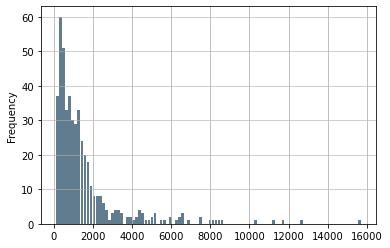

In [44]:
# 看讚數的分佈 y 軸是該讚數的貼文數 來看我們要怎麼取哪個讚數區間資料
commutes = lu_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [45]:
temp = lu_post[(lu_post['like_count'] <= 2000) & (lu_post['like_count'] > 500)] #讚數大於500 小於1000才取 : 201  篇文章
temp

,new_date,message,jieba_results,like_count
121,2019-07-19,今天是風和日麗的好天氣，最適合做公益捐血了！而且偷偷告訴大家一個小秘密，捐完可以瘦一點哦💪\n\n歡迎各位好朋友們，今天下午4：30前快來淡水水碓派出所前，一起加入我們的熱血行列吧！👏👏👏\n\n#熱血公益呂孫綾\n#淡水民主促進協會\n#淡水清水巖\n#淡信慈善基金會,今天 是 風 和 日麗 的 好 天氣 最 適合 做 公益 捐血 了 而且 偷偷 告訴 大家 一個 小 秘密 捐完 可以 瘦 一點 哦 歡迎 各位 好 朋友 們 今天下午 前快 來 淡水 水碓 派出所 前 一起 加入 我們 的 熱血 行列 吧 👏 👏 👏 熱血 公益 呂孫綾 淡水 民主 促進 協會 淡水 清水 巖 淡信 慈善 基金 會,502
122,2019-09-02,【呂孫綾姐姐 x 親子電影院八里歡樂場🎬大成功 】\n\n【不論人與人的感情有多麼深刻都不可能永遠不變，當改變的那天到來也許我們會沮喪、難過，但在負面情緒過後我們也必須審視自己並且調整自己，千萬不要情緒勒索最愛的家人和朋友，這樣才能讓自己成為更好的人】💪💪\n\n昨天 #呂孫綾姐姐親子電影院 在我們 #八里區大埤頂市民活動中心 ，現場有許多大朋友小朋友熱情參與，活動就像播映的 #無敵破壞王2網路大暴走結局一樣，有個完美的Happy Ending❤️\n\n本週六日，呂孫綾姐姐親子電影院將在 #林口區公所 播映【 摯友維尼 】、#三芝區公所 【 馴龍高手3 】，歡迎想看電影的大朋友小朋友一起來去看電影！\n也希望玲玲颱風不要來台灣搗蛋👊👊\n\n9/21(六)、9/22(日)，我們在泰山、石門還有播映電影的場次，有興趣的家長朋友不妨透過以下的資訊，就可以與孩子輕鬆一起來看電影囉！\n\n#座位有限敬請見諒\n\n🎈活動完全免費，採取網路報名，各場次活動資訊歡迎參考下方報名表單！\n\n🔸9/7(六)林口場\n【摯友維尼】\nhttps://forms.gle/ceMmtd2hUWHn5mhZ9\n\n🔸9/8(日)三芝場\n【馴龍高手3】\nhttps://forms.gle/X7Dnjsfb8zeQqksXA\n\n🔸9/21(六)泰山場\n【超人特攻隊2】\nhttps://forms.gle/QbcnkcifVPUsi7MU7\n\n🔸9/22(日)石門場\n【蜘蛛人新宇宙】\nhttps://forms.gle/DucP6YsQMVxRSp6TA,呂孫綾 姐姐 親子電 影院 八里 歡樂場 🎬 大 成功 不論 人 與 人 的 感情 有多麼 深刻 都 不 可能 永遠 不變 當改變 的 那天 到 來 也 許我們 會 沮喪 難過 但 在 負面 情緒過 後 我們 也 必須 審視 自己 並且 調整 自己 千萬 不要 情緒 勒索 最愛的 家人 和 朋友 這樣 才能 讓 自己 成為 更好 的 人 昨天 呂孫綾 姐姐 親子電 影院 在 我們 八里 區大 埤 頂 市民 活動 中心 現場 有 許多大 朋友 小朋友 熱情 參與 活動 就 像 播映 的 無敵 破壞 王 網路 大暴走 結局 一樣 有個 完美 的 ❤ ️ 本週 六日 呂孫綾 姐姐 親子電 影院 將在 林口 區 公所 播映 摯友 維尼 三芝 區 公所 馴龍 高手 歡迎 想 看 電影 的 大 朋友 小朋友 一起 來 去 看 電影 也 希望 玲玲 颱 風 不要 來 台灣 搗蛋 👊 👊 六 日 我們 在 泰山 石門 還有 播映 電影 的 場次 有興趣 的 家長 朋友 不妨 透過 以下 的 資訊 就 可以 與 孩子 輕 鬆 一起 來 看 電影 囉 座位 有限 敬請 見諒 🎈 活動 完全 免費 採取 網路 報名 各場次 活動 資訊 歡迎 參考 下方 報 名表 單 🔸 六 林口 場 摯友 維尼 🔸 日 三芝 場 馴龍 高手 🔸 六 泰山 場 超人 特攻隊 🔸 日 石門場 蜘蛛人 新 宇宙,502
123,2019-06-09,今天三芝小基隆福成宮金面媽祖遶境，我一步一腳印，走遍三芝每一條大街小巷。我始終相信，只要我們一起加油努力，未來一定會幸福成功！\n\n#呂孫綾一步一腳印\n#心存善念金面媽祖保佑\n#2020立委堅定支持呂孫綾\n#在地女兒呂孫綾衷心感謝,今天 三芝 小 基隆 福成 宮金面 媽祖 遶 境 我 一步 一腳 印 走遍 三芝 每一條 大街小巷 我 始終 相信 只要 我們 一起 加油 努力 未來 一定 會 幸福 成功 呂孫綾 一步 一腳 印 心存 善念 金面 媽祖 保佑 立委 堅定 支持 呂孫綾 在 地 女兒 呂孫綾 衷心 感謝,505
124,2019-06-07,午安您好 大家都已經掛上菖蒲，準備好享用美味的粽子了嗎？\n\n孫綾提醒您，糯米不易消化，容易造成腸胃負擔，記得不要吃太多哦！\n\n#端午平安,午安 您好 大家 都 已經 掛上 菖蒲 準備 好 享用 美味 的 粽子 了 嗎 孫綾 提醒您 糯米 不易 消化 容易 造成 腸胃 負擔 記得 不要 吃 太 多 哦 端午 平安,507
125,2019-06-15,今天 #呂孫綾姐姐親子黏土活動，來到 #八里萊茵風情社區囉！\n\n感謝頂罟里洪志成里長、舊城里陳天發里長、社區主委、所有爸爸媽媽阿公阿嬤，一起陪著孫綾和孩子們度過歡樂的午後時光🎈\n\n#八里呂孫綾\n#呂孫綾姐姐親子活動\n#繼續前往下個社區帶來歡笑,今天 呂孫綾 姐姐 親子 黏土 活動 來 到 八里 萊茵風情 社區 囉 感謝 頂 罟 里 洪 志成 里長 舊 城里 陳 天發 里長 社區 主委 所有 爸爸 媽媽 阿公 阿嬤 一起 陪著 孫綾 和 孩子 們 度過 歡樂 的 午後時 光 🎈 八里 呂孫綾 呂孫綾 姐姐 親子 活動 繼續 前往 下個 社區 帶來 歡笑,509
...,...,...,...,...
379,2019-02-26,【成功爭取關渡大橋36年第一次耐震補強工程經費】\n\n關渡大橋是新北市淡水、八里地區聯外的重要廊道，在淡江大橋完工通車前，肩負連結淡水河兩岸生活圈之重責大任。\n\n但自1983年完工通車至今已36餘年，當時的設計與現行公路橋梁耐震設計規範已有出入，積年累月的使用，加上城際間來往交織的車流也不時造成路面變形；位處山腳斷層帶的地理位置也致使橋體、橋墩潛藏安全疑慮，關渡大橋耐震補強工程勢在必行。\n\n從我上任以來，便全力爭取預算，要求交通部儘速辦理關渡大橋耐震補強工程。隨後交通部公路總局成立預算(發包費1億7063萬元)，並於2017年10月進行招標。期間歷經3次流標，我在立法院交通委員會提出質詢，並要求交通部就標案內容重新檢討。2018年5月公路總局重新成立預算(發包費2億2714萬元)，7月重新公告招標，卻又再度經歷3次流廢標。\n\n我擔心耐震補強工程就此流案，加上關渡大橋使用年份日漸增加，進度持續延宕恐怕將影響用路人通行安全，因此持續要求交通部提供關渡大橋招標辦理時程，密切控管、督促部會檢討，並且應針對發包經費合理性重新評估，研議後續招標策略。\n\n2018年11月終於再度成立新預算(發包費2億5506萬元)，12月底開標終於有兩家廠商投標。今年1月31日進行審查會，其中一家廠商符合資格。終於在今天，關渡大橋耐震改善及維修補強工程完成決標，將在開工後兩年內完工！\n\n前後歷經6次流廢標，但我不放棄，持續協調、要求行政部門檢討、並爭取調整預算規模，加上交通部各相關單位的努力，終於讓關渡大橋耐震補強工程又向前跨進了一大步！未來關渡大橋的耐震補強工程、及位於河口的淡江大橋將陸續完工，屆時淡水河兩岸生活圈將會串連得更加緊密，也讓我們淡水北海岸、八里西濱沿線居民進出得更加安全、便利。施工階段我也將持續監督，讓關渡大橋、淡江大橋雙橋工程順利完成！,成功 爭取 關渡 大橋 年 第一次 耐震 補強 工程 經費 關渡 大橋 是 新北市 淡水 八里 地區 聯外 的 重要 廊道 在 淡江大橋 完工 通車 前 肩負 連結 淡水河 兩岸 生活圈 之 重責大任 但 自 年 完工 通車 至今 已 餘年 當時 的 設計 與 現行 公路 橋梁 耐震 設計 規範 已有 出入 積年 累 月 的 使用 加上 城際間 來 往交織 的 車流 也 不時 造成 路面 變形 位處 山腳斷 層 帶 的 地理位置 也 致使 橋體 橋墩 潛藏 安全 疑慮 關渡 大橋 耐震 補強 工程 勢 在 必行 從 我 上任 以來 便 全力 爭取 預算 要求 交通部 儘 速 辦 理 關 渡 大 橋 耐震 補強 工程 隨後 交通部 公路 總局 成立 預算 發包費 億 萬元 並 於 年 月 進行 招標 期間 歷經 次流標 我 在 立法院 交通 委員 會 提出 質詢 並 要求 交通部 就 標案 內容 重新 檢討 年 月 公路 總局 重新 成立 預算 發包費 億 萬元 月 重新 公告 招標 卻 又 再度 經歷 次流 廢標 我 擔心 耐震 補強 工程 就此 流案 加上 關渡 大橋 使用 年份 日漸 增加 進度 持續 延宕 恐怕 將影響 用路 人 通行 安全 因此 持續 要求 交通部 提供 關渡 大橋 招標 辦理 時程 密切 控管 督促 部會 檢討 並且 應 針對 發包 經費 合理性 重新 評估 研議後續 招標 策略 年 月 終於 再度 成立 新 預算 發包費 億 萬元 月底 開標 終於 有 兩家 廠商 投標 今年 月 日 進行 審查 會 其中 一家 廠商 符合 資格 終於 在 今天 關渡 大橋 耐震 改善 及維修 補強 工程 完成 決標 將在 開工後兩年 內 完工 前後歷經

TF-IDF
我們把剛才斷好詞的貼文，轉成list形式，全部放到corpus變數裡面，方便做tf-idf處理。

CountVectorizer算字頻（搭配fit_transform）
TfidfTransformer計算TFIDF

In [46]:
corpus = temp['jieba_results'].values.tolist() #如果不做這個、結果會不同 太generall

In [47]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [48]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,一一,一下,一中,一些,一代,一件,一份,一位,一併,一例,...,鼎沸,鼎盛,鼓勵,鼻遊,齊聚,龍米,龍舟,龐大,龐大且,龜裂
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['未來', '地方', '今天', '大家', '呂孫綾', '紅火蟻', '我們', '淡海新市鎮', '淡水', '林口']
TOP 10 WORDS PER TOPIC #1
['泰山', '小朋友', '影院', '親子電', '台灣', '一起', '我們', '活動', '姐姐', '呂孫綾']
TOP 10 WORDS PER TOPIC #2
['孩子', '一起', '社區', '大家', '里長', '林口', '泰山', '淡水', '活動', '呂孫綾']
TOP 10 WORDS PER TOPIC #3
['大小事', '做好', '總統', '一起', '我們', '認真', '蔡英文', '大家', '呂孫綾', '台灣']
TOP 10 WORDS PER TOPIC #4
['國小', '學習', '社宅', '孩子', '我們', '環境', '呂孫綾', '台灣', '教育', '林口']
TOP 10 WORDS PER TOPIC #5
['我們', '交通', '市政府', '台灣', '泰山', '呂孫綾', '淡江大橋', '新北', '淡水', '工程']
TOP 10 WORDS PER TOPIC #6
['不分', '台灣', '有心', '台商', '認真', '教育', '政府', '大家', '投資', '孩子']


In [50]:

LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['認真', '淡水', '祖師', '平安', '媽祖', '呂孫綾', '我們', '大家', '泰山', '台灣']
TOP 10 WORDS PER TOPIC #1
['一起', '我們', '成績', '呂孫綾有', '大家', '林口', '蔡英文', '總統', '呂孫綾', '台灣']
TOP 10 WORDS PER TOPIC #2
['總統', '新北市', '法律', '蔡英文', '大家', '泰山', '台灣', '呂孫綾', '林口', '淡水']
TOP 10 WORDS PER TOPIC #3
['朋友', '一路', '播映', '資訊', '不要', '電影', '活動', '姐姐', '親子電', '影院']
TOP 10 WORDS PER TOPIC #4
['民進黨', '我們', '大家', '英文', '林口', '呂孫綾', '社宅', '加油', '台灣', '香港']
TOP 10 WORDS PER TOPIC #5
['噪音', '明天', '道路', '新北', '工程', '淡江大橋', '大家', '呂孫綾', '八里', '淡水']
TOP 10 WORDS PER TOPIC #6
['早安', '教育', '三芝', '工程', '第一', '林口', '淡海新市鎮', '呂孫綾', '泰山', '淡水']


In [51]:
#政見做斷詞

politics_lu = politics[politics.姓名 == "呂 孫 綾"].政見.to_string()
politics_lu = re.sub(re_punctuation, "", politics_lu)
politics_lu = re.sub(r'[0-9]','',politics_lu)
politics_lu = re.sub(r'[a-zA-Z]','',politics_lu)
politics_lu = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',politics_lu)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
words = jieba.lcut(politics_lu, cut_all = False)


In [52]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_lu, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',text)
text = re.sub(re_punctuation, "", text)


In [53]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(words)  
word = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=7, random_state=None)

#政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)


TOP 10 WORDS PER TOPIC #0
['過程', '防治', '同時', '訂定', '新思維', '婦幼', '樂活', '基地', '三芝', '公開透明']
TOP 10 WORDS PER TOPIC #1
['零容忍', '因此', '必須', '食品安全', '地區', '拒絕', '進步', '公民參與', '核電', '發展']
TOP 10 WORDS PER TOPIC #2
['在地文創', '國會聽證', '全公開', '八里', '轉型', '四大', '反貪汙', '社會困境', '石門', '保證']
TOP 10 WORDS PER TOPIC #3
['公托制度', '重設驗證', '打造', '影音', '國會改革', '輔導', '議事', '開發', '除役', '計畫']
TOP 10 WORDS PER TOPIC #4
['黑箱', '電網', '配合', '六區', '銜接', '承諾議', '運作', '創新', '安全', '推動']
TOP 10 WORDS PER TOPIC #5
['淡水', '定期', '都市', '海空', '外圈廊帶', '公共安全', '青年住宅', '國土', '居住', '承諾']
TOP 10 WORDS PER TOPIC #6
['世代', '上網', '建設', '利益迴避', '均衡', '強化', '更新', '全透明', '監督', '落實']


In [54]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

過程, 防治, 同時, 訂定, 新思維, 婦幼, 樂活, 基地, 三芝, 公開透明, 零容忍, 因此, 必須, 食品安全, 地區, 拒絕, 進步, 公民參與, 核電, 發展, 在地文創, 國會聽證, 全公開, 八里, 轉型, 四大, 反貪汙, 社會困境, 石門, 保證, 公托制度, 重設驗證, 打造, 影音, 國會改革, 輔導, 議事, 開發, 除役, 計畫, 黑箱, 電網, 配合, 六區, 銜接, 承諾議, 運作, 創新, 安全, 推動, 淡水, 定期, 都市, 海空, 外圈廊帶, 公共安全, 青年住宅, 國土, 居住, 承諾, 世代, 上網, 建設, 利益迴避, 均衡, 強化, 更新, 全透明, 監督, 落實, 

In [55]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#產業升級、園區、高科技園區、加工區 、楠梓、交通、三鐵同構

Counter({'過程': 1,
         '防治': 1,
         '同時': 1,
         '訂定': 1,
         '新思維': 1,
         '婦幼': 1,
         '樂活': 1,
         '基地': 1,
         '三芝': 1,
         '公開透明': 1,
         '零容忍': 1,
         '因此': 1,
         '必須': 1,
         '食品安全': 1,
         '地區': 1,
         '拒絕': 1,
         '進步': 1,
         '公民參與': 1,
         '核電': 1,
         '發展': 1,
         '在地文創': 1,
         '國會聽證': 1,
         '全公開': 1,
         '八里': 1,
         '轉型': 1,
         '四大': 1,
         '反貪汙': 1,
         '社會困境': 1,
         '石門': 1,
         '保證': 1,
         '公托制度': 1,
         '重設驗證': 1,
         '打造': 1,
         '影音': 1,
         '國會改革': 1,
         '輔導': 1,
         '議事': 1,
         '開發': 1,
         '除役': 1,
         '計畫': 1,
         '黑箱': 1,
         '電網': 1,
         '配合': 1,
         '六區': 1,
         '銜接': 1,
         '承諾議': 1,
         '運作': 1,
         '創新': 1,
         '安全': 1,
         '推動': 1,
         '淡水': 4,
         '定期': 1,
         '都市': 1,
         '海空': 1,
     

我們可以用 臉書貼文和政見 Topic word 的交集 會推測
劉世芳的幾個重點
1. 經濟相關的科技 園區和加工區
    - 高科技、發展、產業、加工區、園區、產業、就業、計畫、建設、
2. 楠梓地區
    -楠梓
3. 交通
    -三鐵同構、中油、交通、
4. 環境
    -環境、綠能、

職災 相關tf idf 高 (以下討論臉書貼文)

In [56]:
top_10_message = tfidf_view.sort_values(by = ['孩子'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['孩子'], ascending = False).head(10)

,一一,一下,一中,一些,一代,一件,一份,一位,一併,一例,...,鼎沸,鼎盛,鼓勵,鼻遊,齊聚,龍米,龍舟,龐大,龐大且,龜裂
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.082296,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071009,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.051410,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042464,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[227,]).sort_values(by = 227, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,227
孩子,0.442823
場大,0.292862
呂孫綾承諾,0.292862
星空,0.272677
要給,0.258356
...,...
寒冷,0.000000
富貴角,0.000000
富源,0.000000
密切配合,0.000000


In [58]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[204,]).sort_values(by = 204, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,204
孩子,0.325979
教育,0.310600
家庭,0.288842
公平,0.228223
不能,0.183736
...,...
審會議,0.000000
審慎,0.000000
審判,0.000000
實體,0.000000


In [59]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

243     創園
244     防颱
245     台灣
246     一路
247     一票
248    財產署
249     加入
250    紅火蟻
251     能量
252     五股
253     長輩
254     投資
255     兒少
256     作伴
257    新竹市
258     大橋
259     攝取
260     林口
261     自來
262     一陣
Name: term, dtype: object

In [60]:
#假如以剛剛科學園區相關主題為例 想看tfidf 最高的詞是科學園區的文章
message_newtfidf[message_newtfidf['term']=="紅火蟻"]

,一一,一下,一中,一些,一代,一件,一份,一位,一併,一例,...,鼎盛,鼓勵,鼻遊,齊聚,龍米,龍舟,龐大,龐大且,龜裂,term
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,紅火蟻
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,紅火蟻
250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,紅火蟻


In [61]:
# 會發現文章出現tfidf是產業的很少，很正常 因為出現太多反而tfidf不會高！
temp.iloc[83,]

new_date                                                                                                                                                2019-09-17
message                                         今天我藉由這支影片向各位滅火(蟻)英雄致敬！！\n也讓大家對紅火蟻有基本的防治觀念，期待有一天能讓台灣遠離紅火蟻的威脅。\n\n#紅火蟻防治呂孫綾\n#感謝蔡淑君議員協助\n#感謝林口嘉寶里長黃建邦\n#不分大小事認真做好每件事
jieba_results     今天 我 藉由 這支 影片 向 各位 滅火 蟻 英雄 致敬 也 讓 大家 對紅火蟻 有 基本 的 防治 觀念 期待 有 一天 能 讓 台灣 遠離 紅火蟻 的 威脅   紅火蟻 防治 呂孫綾  感謝 蔡淑君 議員 協助  感謝 林口 嘉寶 里長 黃 建邦  不分 大小事 認真 做好 每件事
like_count                                                                                                                                                     849
Name: 204, dtype: object

來看楠梓 ： 在臉書發文的topic中topic2,4,7 出現很多次楠梓 

In [62]:
message_newtfidf[message_newtfidf['term']=="淡水"]

,一一,一下,一中,一些,一代,一件,一份,一位,一併,一例,...,鼎盛,鼓勵,鼻遊,齊聚,龍米,龍舟,龐大,龐大且,龜裂,term
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,淡水
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,淡水


In [63]:
temp.iloc[10,]

new_date                                                                                                                                                                                                                            2019-07-18
message                                          【來來來！來捐血喔！】\n\n每到7、8月暑假期間，血庫時常會出現血荒，每年我都和淡水民主促進協會ㄧ起舉辦的捐血活動，明天將在淡水水碓派出所前舉行。\n\n誠摯邀請您明天一起到現場捲起衣袖，捐出您的滿腔熱血！\n\n💉時間：7/19(五)08:00-16:30\n💉地點：淡水水碓派出所前\n💉主辦單位：淡水民主促進協會\n💉協辦單位：立法委員呂孫綾、淡水清水巖、淡信慈善基金會
jieba_results     來來 來 來 捐血 喔 每到   月 暑假 期間 血庫 時常會 出現 血荒 每年 我 都 和 淡水 民主 促進 協會 ㄧ 起舉 辦 的 捐血 活動 明天 將在 淡水 水碓 派出所 前舉行  誠摯 邀請 您 明天 一起 到 現場 捲 起 衣袖 捐出 您 的 滿腔 熱血 💉 時間   五      💉 地點 淡水 水碓 派出所 前 💉 主辦 單位 淡水 民主 促進 協會 💉 協辦 單位 立法委員 呂孫綾 淡水 清水 巖 淡信 慈善 基金 會
like_count                                                                                                                                                                                                                                 533
Name: 131, dtype: object

In [64]:
temp.iloc[177,]

new_date                                                                                                                                                                                                                                                                                     2019-12-08
message                                                 【就是今晚！蔡英文·呂孫綾淡水競選總部成立音樂晚會✨】\n\n今晚賴清德副總統候選人、陳建仁副總統『雙副合體，淡水團結挺孫綾』！除此之外，徐國勇部長、林智堅市長、羅文嘉秘書長、李麗芬委員、新北市議員鄭宇恩也將同台讚聲力挺呂孫綾！還有同樣身為淡水女兒的歌手陳怡婷，也將在現場助唱！\n\n邀請您一起在好天氣的夜晚，到現場守民主、護台灣！\n\n🎈時間：今天晚上18:30-21:00\n🎈地點：淡水水碓籃球場\n\n#四年創奇蹟呂孫綾有成績\n#2020台灣要贏\n#守民主護台灣
jieba_results     就是 今晚 蔡英文 · 呂孫綾 淡水 競選總部 成立 音樂 晚會 ✨ 今晚 賴清德 副 總統候選人 陳 建仁 副 總統 雙副合體 淡水 團結 挺 孫綾 除此之外 徐國勇 部長 林智 堅市 長 羅 文嘉 秘書長 李麗芬 委員 新北市 議員 鄭宇恩 也將 同台 讚 聲 力 挺 呂 孫 綾 還有 同樣 身為 淡水 女兒 的 歌手 陳 怡婷 也 將在 現場助 唱 邀請 您 一起 在 好 天氣 的 夜晚 到 現場 守 民主 護 台灣 🎈 時間 今天 晚上      🎈 地點 淡水 水碓 籃球場  四年 創奇 蹟 呂孫綾有 成績   台灣 要贏  守民主護台灣
like_count                                                                                                      

In [65]:
# LDA : 看每篇文章被分配在哪些主題  (tfidf)
#review topic 結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['認真', '淡水', '祖師', '平安', '媽祖', '呂孫綾', '我們', '大家', '泰山', '台灣']
TOP 10 WORDS PER TOPIC #1
['一起', '我們', '成績', '呂孫綾有', '大家', '林口', '蔡英文', '總統', '呂孫綾', '台灣']
TOP 10 WORDS PER TOPIC #2
['總統', '新北市', '法律', '蔡英文', '大家', '泰山', '台灣', '呂孫綾', '林口', '淡水']
TOP 10 WORDS PER TOPIC #3
['朋友', '一路', '播映', '資訊', '不要', '電影', '活動', '姐姐', '親子電', '影院']
TOP 10 WORDS PER TOPIC #4
['民進黨', '我們', '大家', '英文', '林口', '呂孫綾', '社宅', '加油', '台灣', '香港']
TOP 10 WORDS PER TOPIC #5
['噪音', '明天', '道路', '新北', '工程', '淡江大橋', '大家', '呂孫綾', '八里', '淡水']
TOP 10 WORDS PER TOPIC #6
['早安', '教育', '三芝', '工程', '第一', '林口', '淡海新市鎮', '呂孫綾', '泰山', '淡水']


In [66]:
#可以猜猜看第一篇文是哪個topic 
temp.iloc[:,[0,2]]

,new_date,jieba_results
121,2019-07-19,今天 是 風 和 日麗 的 好 天氣 最 適合 做 公益 捐血 了 而且 偷偷 告訴 大家 一個 小 秘密 捐完 可以 瘦 一點 哦 歡迎 各位 好 朋友 們 今天下午 前快 來 淡水 水碓 派出所 前 一起 加入 我們 的 熱血 行列 吧 👏 👏 👏 熱血 公益 呂孫綾 淡水 民主 促進 協會 淡水 清水 巖 淡信 慈善 基金 會
122,2019-09-02,呂孫綾 姐姐 親子電 影院 八里 歡樂場 🎬 大 成功 不論 人 與 人 的 感情 有多麼 深刻 都 不 可能 永遠 不變 當改變 的 那天 到 來 也 許我們 會 沮喪 難過 但 在 負面 情緒過 後 我們 也 必須 審視 自己 並且 調整 自己 千萬 不要 情緒 勒索 最愛的 家人 和 朋友 這樣 才能 讓 自己 成為 更好 的 人 昨天 呂孫綾 姐姐 親子電 影院 在 我們 八里 區大 埤 頂 市民 活動 中心 現場 有 許多大 朋友 小朋友 熱情 參與 活動 就 像 播映 的 無敵 破壞 王 網路 大暴走 結局 一樣 有個 完美 的 ❤ ️ 本週 六日 呂孫綾 姐姐 親子電 影院 將在 林口 區 公所 播映 摯友 維尼 三芝 區 公所 馴龍 高手 歡迎 想 看 電影 的 大 朋友 小朋友 一起 來 去 看 電影 也 希望 玲玲 颱 風 不要 來 台灣 搗蛋 👊 👊 六 日 我們 在 泰山 石門 還有 播映 電影 的 場次 有興趣 的 家長 朋友 不妨 透過 以下 的 資訊 就 可以 與 孩子 輕 鬆 一起 來 看 電影 囉 座位 有限 敬請 見諒 🎈 活動 完全 免費 採取 網路 報名 各場次 活動 資訊 歡迎 參考 下方 報 名表 單 🔸 六 林口 場 摯友 維尼 🔸 日 三芝 場 馴龍 高手 🔸 六 泰山 場 超人 特攻隊 🔸 日 石門場 蜘蛛人 新 宇宙
123,2019-06-09,今天 三芝 小 基隆 福成 宮金面 媽祖 遶 境 我 一步 一腳 印 走遍 三芝 每一條 大街小巷 我 始終 相信 只要 我們 一起 加油 努力 未來 一定 會 幸福 成功 呂孫綾 一步 一腳 印 心存 善念 金面 媽祖 保佑 立委 堅定 支持 呂孫綾 在 地 女兒 呂孫綾 衷心 感謝
124,2019-06-07,午安 您好 大家 都 已經 掛上 菖蒲 準備 好 享用 美味 的 粽子 了 嗎 孫綾 提醒您 糯米 不易 消化 容易 造成 腸胃 負擔 記得 不要 吃 太 多 哦 端午 平安
125,2019-06-15,今天 呂孫綾 姐姐 親子 黏土 活動 來 到 八里 萊茵風情 社區 囉 感謝 頂 罟 里 洪 志成 里長 舊 城里 陳 天發 里長 社區 主委 所有 爸爸 媽媽 阿公 阿嬤 一起 陪著 孫綾 和 孩子 們 度過 歡樂 的 午後時 光 🎈 八里 呂孫綾 呂孫綾 姐姐 親子 活動 繼續 前往 下個 社區 帶來 歡笑
...,...,...
379,2019-02-26,成功 爭取 關渡 大橋 年 第一次 耐震 補強 工程 經費 關渡 大橋 是 新北市 淡水 八里 地區 聯外 的 重要 廊道 在 淡江大橋 完工 通車 前 肩負 連結 淡水河 兩岸 生活圈 之 重責大任 但 自 年 完工 通車 至今 已 餘年 當時 的 設計 與 現行 公路 橋梁 耐震 設計 規範 已有 出入 積年 累 月 的 使用 加上 城際間 來 往交織 的 車流 也 不時 造成 路面 變形 位處 山腳斷 層 帶 的 地理位置 也 致使 橋體 橋墩 潛藏 安全 疑慮 關渡 大橋 耐震 補強 工程 勢 在 必行 從 我 上任 以來 便 全力 爭取 預算 要求 交通部 儘 速 辦 理 關 渡 大 橋 耐震 補強 工程 隨後 交通部 公路 總局 成立 預算 發包費 億 萬元 並 於 年 月 進行 招標 期間 歷經 次流標 我 在 立法院 交通 委員 會 提出 質詢 並 要求 交通部 就 標案 內容 重新 檢討 年 月 公路 總局 重新 成立 預算 發包費 億 萬元 月 重新 公告 招標 卻 又 再度 經歷 次流 廢標 我 擔心 耐震 補強 工程 就此 流案 加上 關渡 大橋 使用 年份 日漸 增加 進度 持續 延宕 恐怕 將影響 用路 人 通行 安全 因此 持續 要求 交通部 提供 關渡 大橋 招標 辦理 時程 密切 控管 督促 部會 檢討 並且 應 針對 發包 經費 合理性 重新 評估 研議後續 招標 策略 年 月 終於 再度 成立 新 預算 發包費 億 萬元 月底 開標 終於 有 兩家 廠商 投標 今年 月 日 進行 審查 會 其中 一家 廠商 符合 資格 終於 在 今天 關渡 大橋 耐震 改善 及維修 補強 工程 完成 決標 將在 開工後兩年 內 完工 前後歷經 次流 廢標 但 我 不放棄 持續 協調 要求 行政部 門檢討 並 爭取 調整 預算 規模 加上 交通部 各相關 單位 的 努力 終於 讓 關渡 大橋 耐震 補強 工程 又 向前 跨進 了 一大步 未來 關渡 大橋 的 耐震 補強 工程 及位 於 河口 的 淡江大橋 將陸續 完工 屆 時 淡水河 兩岸 生活圈 將會 串連 得 更加 緊密 也 讓 我們 淡水北海岸 八里 西濱 沿線 居民 進出 得 更加 安全 便利 施工 階段 我 也將 持續 監督 讓 關渡 大橋 淡江大橋 雙橋 工程 順利 完成
380,2019-10-04,早安 雖然 明天 還要 補班 補課 也 是 為 了 美麗 的 連假 而 努力 喔 呂孫綾 溫馨 提醒 平日 上班 忙碌 還是 要 多多 攝取 補充 各種 新鮮 蔬菜水果 喔 🥬 🥦 🥕 🍠 🌽 🍈 🍓 🍉 🥝 🍎 綾蔡包 呂孫綾 環保購 物袋 水水 去 買 菜 不分 大小事 認真 做好 每件事
381,2019-11-11,小英總統 要來 林口 了 蔡英文 總統 和 我 的 首場 大型 造勢 音樂 晚會 即將 在 林口 與 大家 相見歡 當然 還有 我們 林口 的 好 鄰居 桃園 的 大家 長 鄭文燦市 長 也 會 共 襄盛舉 喔 現場並 邀請 眾多樂界 知名人士 與 樂團 活動 內容 豐富 絕無冷場 邀請 大家 日 晚上 在 林口 運動 公園 溜冰 場 文化 一路 一段 與 仁愛路 二段 一起 走 過路 過千萬別 錯過 喔 林口 呂孫綾 小英總統 與 鄭文燦市 長 一起 和 大家 聽音樂 邀請 大家 來 為 小英 孫綾 加油
382,2019-11-04,期盼 多年 的 自來 水 里長 與 呂孫綾 攜手 合作 通水 囉 我 就任 立委 之 後 林口 嘉寶 里長 黃 建邦 跟 我 反應 當地 因為 地勢 高 又 位處 自來 水管 線 末端 而且 因為 自來 水延管 工程 的 經費過 高 使得 里 內 超過 戶 多位 居民 數 十年 來 都 沒 有 自來 水 可用 僅能 依賴 地下水 山泉水 供應 所 需 一 遇到 豪雨 或 颱 風 水質 就 會 混濁 民眾 就 會 面臨 無水 可用 的 困境 當時 我 邀集 經濟部 水利 署 台灣 自來 水 公司 新北 市政府 林口 區 公所 等 中央 與 地方 機關 進行 協調 一同 努力 為民眾 爭取 自來 水 設施 透過 簡易 自來 水設 施輸 送 自來 水至民眾 家中 並開 創下 了 全國 首例 的 紀錄 實在 非常 不 簡單 在 爭取 的 這段 期間 遇到 了 很多 困難 但是 黃 建邦 里長 展現 出 強烈 的 服務 熱誠及 令人 欽佩 的 意志力 再 加上 蔡淑君 議員 大力 協助 我們 終於 完成 了 這項 任務 讓民眾 不再 憂煩 天氣 狀況 隨時 都 能 享有 便利 的 自來 水 服務 林口 嘉寶里 自來 水 呂孫綾 成功 解決 林口 嘉寶里 用水 並創 下 全國 首例 大家 生活 的 日常 就是 呂孫綾 努力 的 目標 不分 大小事 認真 做好 民生 事


In [67]:
#LDA classification 
temp["topic"]=""#add new column 

doc_topic = LDA.transform(tfidf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()

    temp.iloc[n,4] = topic_most_pr
temp

<ipython-input-67-3dbfd841bfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["topic"]=""#add new column
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,new_date,message,jieba_results,like_count,topic
121,2019-07-19,今天是風和日麗的好天氣，最適合做公益捐血了！而且偷偷告訴大家一個小秘密，捐完可以瘦一點哦💪\n\n歡迎各位好朋友們，今天下午4：30前快來淡水水碓派出所前，一起加入我們的熱血行列吧！👏👏👏\n\n#熱血公益呂孫綾\n#淡水民主促進協會\n#淡水清水巖\n#淡信慈善基金會,今天 是 風 和 日麗 的 好 天氣 最 適合 做 公益 捐血 了 而且 偷偷 告訴 大家 一個 小 秘密 捐完 可以 瘦 一點 哦 歡迎 各位 好 朋友 們 今天下午 前快 來 淡水 水碓 派出所 前 一起 加入 我們 的 熱血 行列 吧 👏 👏 👏 熱血 公益 呂孫綾 淡水 民主 促進 協會 淡水 清水 巖 淡信 慈善 基金 會,502,0
122,2019-09-02,【呂孫綾姐姐 x 親子電影院八里歡樂場🎬大成功 】\n\n【不論人與人的感情有多麼深刻都不可能永遠不變，當改變的那天到來也許我們會沮喪、難過，但在負面情緒過後我們也必須審視自己並且調整自己，千萬不要情緒勒索最愛的家人和朋友，這樣才能讓自己成為更好的人】💪💪\n\n昨天 #呂孫綾姐姐親子電影院 在我們 #八里區大埤頂市民活動中心 ，現場有許多大朋友小朋友熱情參與，活動就像播映的 #無敵破壞王2網路大暴走結局一樣，有個完美的Happy Ending❤️\n\n本週六日，呂孫綾姐姐親子電影院將在 #林口區公所 播映【 摯友維尼 】、#三芝區公所 【 馴龍高手3 】，歡迎想看電影的大朋友小朋友一起來去看電影！\n也希望玲玲颱風不要來台灣搗蛋👊👊\n\n9/21(六)、9/22(日)，我們在泰山、石門還有播映電影的場次，有興趣的家長朋友不妨透過以下的資訊，就可以與孩子輕鬆一起來看電影囉！\n\n#座位有限敬請見諒\n\n🎈活動完全免費，採取網路報名，各場次活動資訊歡迎參考下方報名表單！\n\n🔸9/7(六)林口場\n【摯友維尼】\nhttps://forms.gle/ceMmtd2hUWHn5mhZ9\n\n🔸9/8(日)三芝場\n【馴龍高手3】\nhttps://forms.gle/X7Dnjsfb8zeQqksXA\n\n🔸9/21(六)泰山場\n【超人特攻隊2】\nhttps://forms.gle/QbcnkcifVPUsi7MU7\n\n🔸9/22(日)石門場\n【蜘蛛人新宇宙】\nhttps://forms.gle/DucP6YsQMVxRSp6TA,呂孫綾 姐姐 親子電 影院 八里 歡樂場 🎬 大 成功 不論 人 與 人 的 感情 有多麼 深刻 都 不 可能 永遠 不變 當改變 的 那天 到 來 也 許我們 會 沮喪 難過 但 在 負面 情緒過 後 我們 也 必須 審視 自己 並且 調整 自己 千萬 不要 情緒 勒索 最愛的 家人 和 朋友 這樣 才能 讓 自己 成為 更好 的 人 昨天 呂孫綾 姐姐 親子電 影院 在 我們 八里 區大 埤 頂 市民 活動 中心 現場 有 許多大 朋友 小朋友 熱情 參與 活動 就 像 播映 的 無敵 破壞 王 網路 大暴走 結局 一樣 有個 完美 的 ❤ ️ 本週 六日 呂孫綾 姐姐 親子電 影院 將在 林口 區 公所 播映 摯友 維尼 三芝 區 公所 馴龍 高手 歡迎 想 看 電影 的 大 朋友 小朋友 一起 來 去 看 電影 也 希望 玲玲 颱 風 不要 來 台灣 搗蛋 👊 👊 六 日 我們 在 泰山 石門 還有 播映 電影 的 場次 有興趣 的 家長 朋友 不妨 透過 以下 的 資訊 就 可以 與 孩子 輕 鬆 一起 來 看 電影 囉 座位 有限 敬請 見諒 🎈 活動 完全 免費 採取 網路 報名 各場次 活動 資訊 歡迎 參考 下方 報 名表 單 🔸 六 林口 場 摯友 維尼 🔸 日 三芝 場 馴龍 高手 🔸 六 泰山 場 超人 特攻隊 🔸 日 石門場 蜘蛛人 新 宇宙,502,3
123,2019-06-09,今天三芝小基隆福成宮金面媽祖遶境，我一步一腳印，走遍三芝每一條大街小巷。我始終相信，只要我們一起加油努力，未來一定會幸福成功！\n\n#呂孫綾一步一腳印\n#心存善念金面媽祖保佑\n#2020立委堅定支持呂孫綾\n#在地女兒呂孫綾衷心感謝,今天 三芝 小 基隆 福成 宮金面 媽祖 遶 境 我 一步 一腳 印 走遍 三芝 每一條 大街小巷 我 始終 相信 只要 我們 一起 加油 努力 未來 一定 會 幸福 成功 呂孫綾 一步 一腳 印 心存 善念 金面 媽祖 保佑 立委 堅定 支持 呂孫綾 在 地 女兒 呂孫綾 衷心 感謝,505,0
124,2019-06-07,午安您好 大家都已經掛上菖蒲，準備好享用美味的粽子了嗎？\n\n孫綾提醒您，糯米不易消化，容易造成腸胃負擔，記得不要吃太多哦！\n\n#端午平安,午安 您好 大家 都 已經 掛上 菖蒲 準備 好 享用 美味 的 粽子 了 嗎 孫綾 提醒您 糯米 不易 消化 容易 造成 腸胃 負擔 記得 不要 吃 太 多 哦 端午 平安,507,5
125,2019-06-15,今天 #呂孫綾姐姐親子黏土活動，來到 #八里萊茵風情社區囉！\n\n感謝頂罟里洪志成里長、舊城里陳天發里長、社區主委、所有爸爸媽媽阿公阿嬤，一起陪著孫綾和孩子們度過歡樂的午後時光🎈\n\n#八里呂孫綾\n#呂孫綾姐姐親子活動\n#繼續前往下個社區帶來歡笑,今天 呂孫綾 姐姐 親子 黏土 活動 來 到 八里 萊茵風情 社區 囉 感謝 頂 罟 里 洪 志成 里長 舊 城里 陳 天發 里長 社區 主委 所有 爸爸 媽媽 阿公 阿嬤 一起 陪著 孫綾 和 孩子 們 度過 歡樂 的 午後時 光 🎈 八里 呂孫綾 呂孫綾 姐姐 親子 活動 繼續 前往 下個 社區 帶來 歡笑,509,5
...,...,...,...,...,...
379,2019-02-26,【成功爭取關渡大橋36年第一次耐震補強工程經費】\n\n關渡大橋是新北市淡水、八里地區聯外的重要廊道，在淡江大橋完工通車前，肩負連結淡水河兩岸生活圈之重責大任。\n\n但自1983年完工通車至今已36餘年，當時的設計與現行公路橋梁耐震設計規範已有出入，積年累月的使用，加上城際間來往交織的車流也不時造成路面變形；位處山腳斷層帶的地理位置也致使橋體、橋墩潛藏安全疑慮，關渡大橋耐震補強工程勢在必行。\n\n從我上任以來，便全力爭取預算，要求交通部儘速辦理關渡大橋耐震補強工程。隨後交通部公路總局成立預算(發包費1億7063萬元)，並於2017年10月進行招標。期間歷經3次流標，我在立法院交通委員會提出質詢，並要求交通部就標案內容重新檢討。2018年5月公路總局重新成立預算(發包費2億2714萬元)，7月重新公告招標，卻又再度經歷3次流廢標。\n\n我擔心耐震補強工程就此流案，加上關渡大橋使用年份日漸增加，進度持續延宕恐怕將影響用路人通行安全，因此持續要求交通部提供關渡大橋招標辦理時程，密切控管、督促部會檢討，並且應針對發包經費合理性重新評估，研議後續招標策略。\n\n2018年11月終於再度成立新預算(發包費2億5506萬元)，12月底開標終於有兩家廠商投標。今年1月31日進行審查會，其中一家廠商符合資格。終於在今天，關渡大橋耐震改善及維修補強工程完成決標，將在開工後兩年內完工！\n\n前後歷經6次流廢標，但我不放棄，持續協調、要求行政部門檢討、並爭取調整預算規模，加上交通部各相關單位的努力，終於讓關渡大橋耐震補強工程又向前跨進了一大步！未來關渡大橋的耐震補強工程、及位於河口的淡江大橋將陸續完工，屆時淡水河兩岸生活圈將會串連得更加緊密，也讓我們淡水北海岸、八里西濱沿線居民進出得更加安全、便利。施工階段我也將持續監督，讓關渡大橋、淡江大橋雙橋工程順利完成！,成功 爭取 關渡 大橋 年 第一次 耐震 補強 工程 經費 關渡 大橋 是 新北市 淡水 八里 地區 聯外 的 重要 廊道 在 淡江大橋 完工 通車 前 肩負 連結 淡水河 兩岸 生活圈 之 重責大任 但 自 年 完工 通車 至今 已 餘年 當時 的 設計 與 現行 公路 橋梁 耐震 設計 規範 已有 出入 積年 累 月 的 使用 加上 城際間 來 往交織 的 車流 也 不時 造成 路面 變形 位處 山腳斷 層 帶 的 地理位置 也 致使 橋體 橋墩 潛藏 安全 疑慮 關渡 大橋 耐震 補強 工程 勢 在 必行 從 我 上任 以來 便 全力 爭取 預算 要求 交通部 儘 速 辦 理 關 渡 大 橋 耐震 補強 工程 隨後 交通部 公路 總局 成立 預算 發包費 億 萬元 並 於 年 月 進行 招標 期間 歷經 次流標 我 在 立法院 交通 委員 會 提出 質詢 並 要求 交通部 就 標案 內容 重新 檢討 年 月 公路 總局 重新 成立 預算 發包費 億 萬元 月 重新 公告 招標 卻 又 再度 經歷 次流 廢標 我 擔心 耐震 補強 工程 就此 流案 加上 關渡 大橋 使用 年份 日漸 增加 進度 持續 延宕 恐怕 將影響 用路 人 通行 安全 因此 持續 要求 交通部 提供 關渡 大橋 招標 辦理 時程 密切 控管 督促 部會 檢討 並且 應 針對 發包 經費 合理性 重新 評估 研議後續 招標 策略 年 月 終於 再度 成立 新 預算 發包費 億 萬元 月底 開標 終於 有 兩家 廠商 投標 今年 月 日 進行 審查 會 其中 一家 廠商 符合 資格 終於 在 今天 關渡 大橋 耐震 改善 及維修 補強 工程 完成 決

可以看到第19 貼文 真的是和topic5:服務 有關
        23貼文 也屬於topic4: 市場 相關

In [68]:
Counter(temp.iloc[-20:, 4])
#這邊可以看到在讚數top20 多的那些文章中 哪些主題比較熱門
#Topic 0,5,7 這些主題相關比較熱門

Counter({2: 3, 4: 3, 3: 1, 1: 6, 5: 3, 0: 2, 6: 2})

臉書發文的Topic 0,5,7比較常出現 
TOP 10 WORDS PER TOPIC #0
['高雄市', '大家', '一抹黑', '一天', '注意', '安全', '世芳', '朋友', '分享', '台灣']

TOP 10 WORDS PER TOPIC #5
['美國', '工程', '我們', '大雨', '改變', '提高', '國家', '自由', '發言', '台灣']

TOP 10 WORDS PER TOPIC #7
['經濟', '軍人節', '問好', '自由黃昏市場', '初選', '台灣', '市長', '楠梓', '我們', '韓市']

回去對政見做印證
政見Topic 
TOP 10 WORDS PER TOPIC #0
['東西', '共同', '安居樂業', '帶動', '文化', '強化', '保存', '交通', '政策', '推動']
TOP 10 WORDS PER TOPIC #1
['實現', '交流', '新綠園', '北上', '地方', '廣設', '升級', '結合', '規劃', '園區']
TOP 10 WORDS PER TOPIC #2
['家庭', '延續', '南遷', '宿舍', '檢討', '左楠', '綠能', '黨產處', '高科技', '開闢']
TOP 10 WORDS PER TOPIC #3
['廠區', '啟動', '移入', '聯外', '通過', '接國', '引入', '政黨', '功能', '盡速']
TOP 10 WORDS PER TOPIC #4
['整合', '區的', '道國', '中心', '打造', '重新', '楠梓', '正義', '形成', '總部']
TOP 10 WORDS PER TOPIC #5
['觀光', '活化', '朝向', '建立', '融入', '三鐵共構', '眷村', '自主', '發展', '中油']
TOP 10 WORDS PER TOPIC #6
['財稅', '追求', '照護', '人口', '就業', '安置', '新門戶', '生態', '社區', '轉型']
TOP 10 WORDS PER TOPIC #7
['持續', '環境', '十字', '打通', '生活', '台灣', '加工區', '防衛', '聚落', '產業']

楠梓在政見中有出現、且在臉書發文也出現不少次，可以互相對應，算是政見、發文互相有符合的詞
但是除了楠梓以外 其他政見比較少在發文中提到
且上次數字型資料分析結果，劉世芳讚數多的貼文言詞都比較有侵略性，內容多數在品評時事的過失，有點蹭時事熱度的感覺，臉書發文的目的比較不是以政見作為考量。

In [69]:
#politics_word
match_column = list(set(words).intersection(vectorizer.get_feature_names()))
match_column

['區域',
 '淡水',
 '公共安全',
 '世代',
 '實踐',
 '八里',
 '提出',
 '物流',
 '參與',
 '公共',
 '經濟',
 '地方發展',
 '發展',
 '功能',
 '林口',
 '拒絕',
 '社區',
 '文化',
 '立委',
 '全面',
 '轉型',
 '新生',
 '銜接',
 '石門',
 '爭取',
 '品質',
 '承諾',
 '進步',
 '過程',
 '更新',
 '揭露',
 '產業',
 '中心',
 '進度',
 '升級',
 '改革',
 '觀光',
 '安全',
 '資訊',
 '創新',
 '紀錄',
 '地區',
 '影音',
 '強化',
 '擴大',
 '零容忍',
 '協助',
 '政治',
 '活化',
 '必須',
 '帶動',
 '完工',
 '回應',
 '都市',
 '完善',
 '台灣',
 '新北市',
 '同時',
 '轉播',
 '自然',
 '打造',
 '建設',
 '泰山',
 '海空',
 '配合',
 '落實',
 '防治',
 '基地',
 '公益',
 '監督',
 '三芝',
 '輕軌',
 '全紀錄',
 '實現',
 '居住',
 '因此',
 '確保',
 '民主',
 '啟動',
 '工程',
 '推動',
 '除役',
 '多個',
 '創意',
 '輔導',
 '提升',
 '民進黨',
 '計畫',
 '開發',
 '芝投公路',
 '價值',
 '選區',
 '舉辦',
 '制度',
 '整個',
 '安心']

In [70]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一一,一下,一中,一些,一代,一件,一份,一位,一併,一例,...,鼎沸,鼎盛,鼓勵,鼻遊,齊聚,龍米,龍舟,龐大,龐大且,龜裂
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[262,]

new_date                                                                                                                              2019-09-21
message                                    今天天公雖然沒有作美，雨勢一陣一陣，但是澆熄不了我們鄉親的熱情，我們就是喜歡運動、熱愛健康啦！\n\n#淡水玄聖宮健走呂孫綾\n#三芝體育會健走呂孫綾\n#下雨天依然動起來\n#不分大小事認真做好每件事
jieba_results     今天 天公 雖然 沒有 作美 雨勢 一陣 一陣 但是 澆 熄 不了 我們 鄉親 的 熱情 我們 就是 喜歡 運動 熱愛 健康 啦  淡水 玄聖 宮健 走 呂孫綾  三芝 體育會 健走 呂孫綾  下雨天 依然 動起 來  不分 大小事 認真 做好 每件事
like_count                                                                                                                                  1989
topic                                                                                                                                          1
Name: 383, dtype: object

In [72]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,區域,淡水,公共安全,世代,實踐,八里,提出,物流,參與,公共,...,民進黨,計畫,開發,芝投公路,價值,選區,舉辦,制度,整個,安心
0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,1,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)

<ipython-input-73-3a73ba8f1e8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


In [74]:
match_document_politics

,區域,淡水,公共安全,世代,實踐,八里,提出,物流,參與,公共,...,計畫,開發,芝投公路,價值,選區,舉辦,制度,整個,安心,sum
0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,1,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,27
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11


In [75]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 200篇中會有8篇有包含政策相關的


24.520833333333332

In [76]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) # 相關度


0.09323510773130544